# Bedform Classification based on Free Surface Images using CNNs 

- **Introduction:** In this notebook, I capture the details for my multi-class classifcation project based on a Convolutional Neural Network. This analysis is for a project listed on <a href="https://web.stanford.edu/~sakshamg/portfolio/bathymetry_inversion">my website</a>. I strongly recommend a quick reading of the introduction there to get an overview of what's to follow. If you are interested in more details, you can see <a href="https://web.stanford.edu/~sakshamg/assets/docs/JFM1_R1.pdf">my publication</a> which is under review. 


- **Happy to provide Data access:** The data for the following work was acquried by me in Stanford's Bob and Norma Street Environmental Fluid Mechanics Lab as part of a proof-of-concept study. **I am all for open science**, so please contact me if you would like to access the full data and we can work something out. It's not being publicly circulated *yet* becasue I haven't hashed out the format for circulation.


- **Background knowledge for CNN**: Going forward I will also be assuming that the reader is familiar with basic NN theory and the convolutional framework. If not, don't worry and <a href="https://developers.google.com/machine-learning/practica/image-classification/convolutional-neural-networks">refresh your understanding here </a>. There are exercises there which were helpful to me. 

## Contents:
1. Introduction to muticlass classification framework and data
    1. Data organization
    2. Visualize the image data
3. Building a Small Convnet from Scratch
4. Compiling the model
5. Training the net
6. Saving the model for future usage
7. Plotting the model Loss and Accuracy
8. Test Set Predictions, Confusion Matrix, Errors in Predictions
    1. Predict on the test set
    2. Save test set accuracy
    3. Function for making confusion matrix

## 1. Introduction to multiclass classification framework and data

The data is composed of images that are labelled as one of the four categories:
- Canopy
- Corals
- Rocks
- Dunes

What this means is that the images of the free surface of the water (our dataset) are taken for one of the above 4 bottom bedform conditions.

Build a classifier model that is able to distinguish the four type of images. 

In [12]:
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

root_path =  '.'

To make the free-surface patterns observed in the raw images more pronounced, I subtracted consecutive frames (taken at a rate of 16 frames per second) to create "difference" images, which were used for all of my analyses.

In [10]:
im_type = 'difference' # difference images as opposed to raw images
training_time = 1 # are we training? [1] or just loading data and looking at the stored model history? [0]
loading_saved_test_data = 0 # we are not loading stored model history

### Data Organization
For each of the bedforms, there were sub-cases that correspond to different water depths and flow speeds. I will represent them as `case_ij` format where `i` is the index key for depth of flow variable and `j` is the index key for the flow speed variable. The classifier is agnostic to flow-condition -- i.e.-- *All images for a given bedform are labelled into a single category*

Let's define the data directories

In [17]:
base_dir = os.path.join(root_path,'train-val-test_data') 
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

print(os.listdir(train_dir))
print(os.listdir(validation_dir))
print(os.listdir(test_dir))

['canopy', 'corals', 'dunes', 'rocks']
['canopy', 'corals', 'dunes', 'rocks']
['canopy', 'corals', 'dunes', 'rocks']


Sample for the data tree in the `train` folder. Similar structure for `validation` folders:

`
train
├── canopy
│   └── case_11
│   └── case_12
│   └── case_13
│   └── case_21
│   └── case_22
│   └── case_23
│   └── case_31
│   └── case_32
│   └── case_33
├── corals
│   └── case_ij
│   └── ...
├── dunes
│   └── case_ij
│   └── ...
└── rocks
│   └── case_mn
│   └── ...`

#### IMPORTANT REMARK:
Generally, one would want the `validation` and `test` set distributions to be the same. But for my work I am designing the test set to contain flow conditions different from those in the `training` set. THIS IS UNCONVENTIONAL. The beauty and the key insight (spoiler alert) is that the model trained on some flow conditions is able to learn distinguishing features of the bedform such that it performs really well on the test set flow conditions (way above average random chance accuracy of 25%).

### Visualize the Image Data
My camera settings were such that I get 3 channeled images (RGB) but in reality the images are monochrome such that all channels are identical. I just need a single channel for analyses. The original images were 1024 $\times$ 1028 but scaled and resized for computational efficiency using the `skimage.transform` library's `rescale`, `resize` functions (preprocessing done separately)

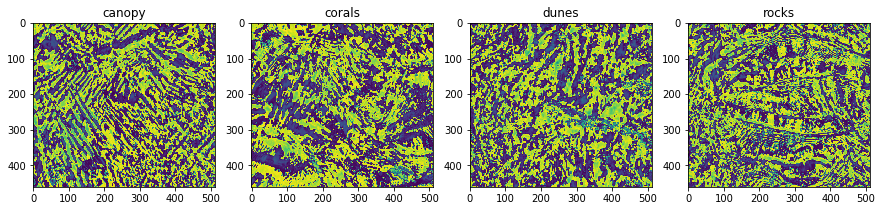

In [35]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# keras.preprocessing is the data preprocessing module of the keras deep learning library
from keras.preprocessing.image import img_to_array, load_img
import random


def plotSample(bed, fig, axes, cc):
    """
        Returns a matplotlib subplot containing the sample picture of the free surface.

        Args:
            bed: one of the four bedform classes ['canopy', 'corals', 'dunes', 'rocks']
            fig, axes : plot base for subplots
            cc : index of list item  for four bedform classes ['canopy', 'corals', 'dunes', 'rocks']
        """
    train_bed_dir = os.path.join(train_dir, bed)
    case_dir = os.path.join(train_bed_dir,'case_23')
    img_files = [os.path.join(case_dir,f) for f in os.listdir(case_dir)]
    img_path = img_to_array(load_img(random.choice(img_files)))/255
    img_path = img_to_array(load_img(random.choice(img_files)))/255  
    axes[cc].imshow(img_path[:,:,0]) # The images are monochrome so all 3 image channels for my case are equivalent
    axes[cc].title.set_text(bed)

fig, axes = plt.subplots(1, 4,figsize=(15,20))
beds = os.listdir(train_dir)    
for cc, bed in enumerate(beds):
    plotSample(bed, fig, axes, cc)

Remark how different the flow signatures look for this flow condition. Of course distinguishability becomes harder for changing flow conditions, and signature differences are not as discernible for other samples. Which is why the need for deep learning!

## 2. Building a Small Convnet from Scratch

Classifier will be built using the `keras` library that uses `tensorflow-v2` as its backend. I stacked four `{convolution + relu + maxpooling}` modules followed by two fully connected layers. Convolution filters operated on 16×16, 10×10, 5×5, and 3×3 windows with a stride of 1 and the `same` padding. Our maxpooling layers operated on 2×2 windows with a `stride` of 2. There were 16, 16, 32, and 64 `filters`, respectively, for each convolutional layer. 

In [5]:
import keras
from keras import layers
from keras import Model

Note that the hyperparameters discussed above and used in the model below are from the process of extensively grid-searching over the domain of selected hyperparameters value ranges while cross-validating. I minimize the training and validation errors. Recall that technically I do not have a test set whose distribution matched the validation set's

In [6]:
# Our input feature map is 224x224x3: 224x224 for the image pixels, and 3 for
# the three color channels: R, G, and B -- but they are identical as the images are monochrome
# so we will need a Lambda layer to access only a single channel

img_input = layers.Input(shape=(224,224, 3))

input_shape = img_input.shape #
output_shape1 = tuple(input_shape[1:3] + (1,))
print(output_shape1)
# following line extracts only the first channel in this image 
img_input1 = layers.Lambda(lambda x: x[:,:,:,0:1], output_shape = output_shape1)(img_input)
print(img_input1)


# Zeroth convolution extracts 8 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
zeroth_module_filt = 16
x = layers.Conv2D(16, zeroth_module_filt, padding = 'same', activation='relu')(img_input1)
x = layers.MaxPooling2D(2)(x)

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
first_module_filt = 10
x = layers.Conv2D(16, first_module_filt, padding = 'same',activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
second_module_filt = 5
x = layers.Conv2D(32, second_module_filt, padding = 'same',activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
third_module_filt = 3
x = layers.Conv2D(64, third_module_filt, padding = 'same',activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and softmax activation
output = layers.Dense(4, activation='softmax')(x)

model = Model(img_input, output)


# summarize the model architecture:
model.summary() 

(224, 224, 1)
Tensor("lambda_1/strided_slice:0", shape=(None, 224, 224, 1), dtype=float32)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 16)      4112      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 16)      25616     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 16)        0         
__________________________________

The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the feature map.

## 3. Compile the model

Next, I'll configure the specifications for model training. I will train the model with the `categorical_crossentropy` loss, because it's a multi-class classification problem and our final activation is a softmax. I will use the `rmsprop` optimizer with a learning rate of `0.001`. During training, I will want to monitor classification accuracy.

Optimizers like `stochastic gradient descent` (SGD), `Adam` and `Adagrad`  were also found to work well.

In [7]:
from keras.optimizers import RMSprop
# from keras.optimizers import Adam
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc']) 

### Data preprocessing -- Normalization

Data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In this case, I will preprocess our images by normalizing the pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range).

The *generators* used below are basically workhorses for fetching the data from my `train`, `validation` and `test` directories while also repsonsible for batch processing the images therein for training

In [8]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255) 
test_final_datagen = ImageDataGenerator(rescale = 1./255)

#--------------------------BATCH SIZE----------------------------------------------------#
bs = 50 
#----------------------------------------------------------------------------------------#

#--------------------------TRAIN GENERATOR-----------------------------------------------#

# Flow training images in batches of 'bs' using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(224,224),  # All images will be resized to 224x224
        batch_size=bs, # number of images in a batch
        class_mode='categorical')
print(train_generator)

#--------------------------VALIDATION GENERATOR------------------------------------------#
# Flow validation images in batches of 'bs' using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(224,224),
        batch_size=bs,
        class_mode='categorical')

Found 32000 images belonging to 4 classes.
Found 9600 images belonging to 4 classes.


In [9]:
#--------------------------VALIDATION GENERATOR------------------------------------------#

test_generator = test_final_datagen.flow_from_directory(
        test_dir,
        target_size=(224,224),  # All images will be resized to 224x224
        batch_size=1, # number of images in a batch
        shuffle = False, 
        # this shuffling should not matter as the errors in the test set are predicted based on 1 image at a time
        class_mode='categorical')

Found 8000 images belonging to 4 classes.


## 4. Training the net
Go Training! Suggestion: You could also use `tensorboard` for saving the model state on the go for online visialization and monitoring. (it's a small addition to the training code)

In [11]:
if training_time == 1:
    history = model.fit_generator(
          train_generator,
          steps_per_epoch=int(32000/bs),  # 32000 images = batch_size * steps
          epochs=30,
          validation_data=validation_generator,
          validation_steps=int(9600/bs),  #9600 images = batch_size * steps
          verbose=2)

Epoch 1/30
 - 297s - loss: 0.7587 - acc: 0.7064 - val_loss: 0.0429 - val_acc: 0.9550
Epoch 2/30
 - 285s - loss: 0.1293 - acc: 0.9542 - val_loss: 0.0846 - val_acc: 0.9779
Epoch 3/30
 - 286s - loss: 0.0663 - acc: 0.9789 - val_loss: 0.0673 - val_acc: 0.9712
Epoch 4/30
 - 286s - loss: 0.0549 - acc: 0.9835 - val_loss: 0.0073 - val_acc: 0.9814
Epoch 5/30
 - 287s - loss: 0.0428 - acc: 0.9872 - val_loss: 0.0856 - val_acc: 0.9807
Epoch 6/30
 - 292s - loss: 0.0452 - acc: 0.9898 - val_loss: 0.1787 - val_acc: 0.9807
Epoch 7/30
 - 285s - loss: 0.0472 - acc: 0.9902 - val_loss: 0.0148 - val_acc: 0.9803
Epoch 8/30
 - 284s - loss: 0.0588 - acc: 0.9903 - val_loss: 0.0344 - val_acc: 0.9865
Epoch 9/30
 - 290s - loss: 0.0505 - acc: 0.9913 - val_loss: 0.0152 - val_acc: 0.9858
Epoch 10/30
 - 287s - loss: 0.0479 - acc: 0.9922 - val_loss: 5.5916e-04 - val_acc: 0.9843
Epoch 11/30
 - 284s - loss: 0.0431 - acc: 0.9929 - val_loss: 2.6463e-06 - val_acc: 0.9839
Epoch 12/30
 - 284s - loss: 0.0561 - acc: 0.9926 - val_

## 5. Saving model
We need to do this to access model weights for predicting in the future. Or otherwise you have to train again!

In [12]:
from keras.models import load_model
import pickle 
if training_time == 1:
    # save the model
    model.save('logs/Conv2D_{}.h5'.format(im_type))  # creates a HDF5 file 
    with open('logs/trainHistoryDict_conv2D_{}.pickle'.format(im_type), 'wb') as file_pi:
        pickle.dump(history, file_pi)

In [13]:
if training_time == 0:
    # loading the saved model
    from keras.models import load_model
    import pickle 

    model = load_model('logs/Conv2D_{}.h5'.format(im_type))
    # Now run model.compile from before
    with open('logs/trainHistoryDict_conv2D_{}.pickle'.format(im_type), 'rb') as file_pi:
        history = pickle.load(file_pi)

In [14]:
avg_train_acc = np.average(history.history['acc'][10:])*100
avg_valid_acc = np.average(history.history['val_acc'][10:])*100
print("Average training acc: ", avg_train_acc)
print("Average validation acc: ", avg_valid_acc)

Average training acc:  99.45921897888184
Average validation acc:  98.60572904348373


## 6. Plotting Accuracy, Loss for the Model from history (not tensorboard)
Let's plot the training/validation accuracy and loss as collected during training:

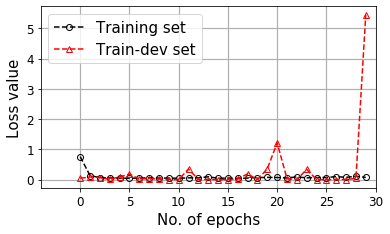

In [15]:
# Retrieve a list of accuracy results on training and test data sets for each training epoch
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

acc = history.history['acc']
val_acc = history.history['val_acc']
c = np.savetxt('logs/train_acc_{}.txt'.format(im_type), acc, delimiter =', ')
d = np.savetxt('logs/val_acc_{}.txt'.format(im_type), val_acc, delimiter =', ')
loss = history.history['loss']
val_loss = history.history['val_loss']
e = np.savetxt('logs/train_loss_{}.txt'.format(im_type), loss, delimiter =', ')
g = np.savetxt('logs/val_loss_{}.txt'.format(im_type), val_loss, delimiter =', ')
# Get number of epochs
epochs = range(len(acc))
totalepochs = np.savetxt('logs/total_epochs_{}.txt'.format(im_type), epochs, delimiter =', ')

plt.figure()
# Plot training and validation accuracy per epoch
plt.plot(epochs, loss,  label='Training set',marker='o', fillstyle='none',linestyle='--',color='k')
plt.plot(epochs, val_loss, label='Train-dev set',marker='^', fillstyle='none',linestyle='--',color='red')
plt.ylabel('Loss value', fontsize = 15)
plt.xlabel('No. of epochs', fontsize = 15)
plt.legend(loc="best", fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim((-4, 30))
plt.grid(True, linewidth=1.2)
plt.subplots_adjust(bottom=0.25)
plt.rcParams['figure.figsize'] = (6, 6)
plt.savefig('plots/Loss for Keras Conv2D {}.png'.format(im_type))

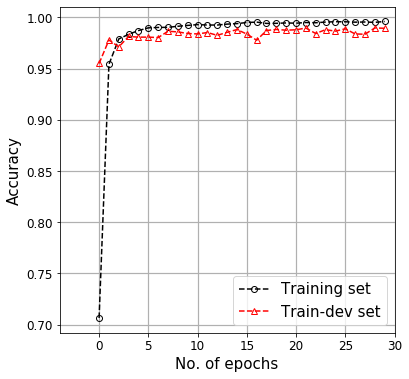

In [16]:
plt.figure()
# Plot training and validation loss per epoch
plt.plot(epochs, acc,  label='Training set',marker='o', fillstyle='none',linestyle='--',color='k')
plt.plot(epochs, val_acc, label='Train-dev set',marker='^', fillstyle='none',linestyle='--',color='red')
plt.ylabel('Accuracy', fontsize = 15)
plt.xlabel('No. of epochs', fontsize = 15)
plt.legend(loc="lower right", fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim((-4, 30))
plt.grid(True, linewidth=1.2)
plt.rcParams['figure.figsize'] = (6, 6)
plt.savefig('plots/Accuracy for Keras Conv2D {}.png'.format(im_type))

## 7. Test Set Predictions, Confusion Matrix, Errors in Predictions
This test set consists of flow conditions that are different from the training set (which has same distribution as the validation set). The power and insight of this whole process lies in the fact that the model learns the distinguishing features for the bedforms in the training phase and performs really well (above 25% rand chance accuracy) on these heretofore unseen test flow conditions.


The following snippet is used *a posteriori* to do some plotting. Not during training time

In [17]:
if loading_saved_test_data == 1:
    import pickle
    with open('logs/testset_data Conv2D {}.pickle'.format(im_type), 'rb') as f:
        filenames, nb_samples, predictions, predicted_classes, ground_truth, errors, label2index, class_names, test_acc = pickle.load(f)

    with open('logs/acc Conv2D {}.pickle'.format(im_type), 'rb') as g:
        avg_train_acc, avg_valid_acc, test_acc = pickle.load(g)
    print(avg_train_acc, avg_valid_acc, test_acc)

### Predicting on the test set

In [18]:
import numpy as np
import itertools

if loading_saved_test_data != 1:
    filenames = test_generator.filenames
    nb_samples = len(filenames)
    desired_batch_size = 1 # same as the one of the test_generator
    predictions = model.predict_generator(test_generator, steps = np.ceil(nb_samples/desired_batch_size), verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    ground_truth = test_generator.classes
    errors = np.where(predicted_classes != ground_truth)[0]
    test_acc = (1-(len(errors)/len(ground_truth)))*100
    print("percent_accuracy in test case predictions = {} %".format(test_acc))

    # Get the label to class mapping from the generator
    label2index = test_generator.class_indices
    class_names = []
    for k,v in label2index.items():
        class_names.append(k)

8000/8000 [==============================] - 73s 9ms/step
percent_accuracy in test case predictions = 64.375 %


### Save the training, validation and test accuracies for later use and plotting

In [19]:
# saving test time variables
if loading_saved_test_data == 0:
    import pickle
    with open('logs/testset_data Conv2D {}.pickle'.format(im_type), 'wb') as f:
        pickle.dump([filenames, nb_samples, predictions, predicted_classes, 
                     ground_truth, errors, label2index, class_names, test_acc], f)

    with open('logs/acc Conv2D {}.pickle'.format(im_type), 'wb') as g:
        pickle.dump([avg_train_acc, avg_valid_acc, test_acc], g)
        
    print(avg_train_acc, avg_valid_acc, test_acc)

99.45921897888184 98.60572904348373 64.375


### Function for making confusion matrix

In [20]:
def plot_confusion_matrix(cm, class_names):
        """
        Returns a matplotlib figure containing the plotted confusion matrix.

        Args:
            cm (array, shape = [n, n]): a confusion matrix of integer classes
            class_names (array, shape = [n]): String names of the integer classes
        """
        figure = plt.figure(figsize=(5, 5))
        pp = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=0, fontsize=12)
        plt.yticks(tick_marks, class_names, fontsize=12)

        # Normalize the confusion matrix.
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

        # Use white text if squares are dark; otherwise black.
        threshold = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                color = "white" if cm[i, j] > threshold else "black"
                plt.text(j, i, cm[i, j], horizontalalignment="center", color=color, fontsize = 15, weight="bold")

        plt.tight_layout()
        plt.ylabel('True label', fontsize=14, fontweight='bold')
        plt.xlabel('Predicted label', fontsize=14, fontweight='bold') 
        plt.subplots_adjust(bottom=0.1, left=.25)
        return figure

##### Plot normalized confusion matrix

<Figure size 432x432 with 0 Axes>

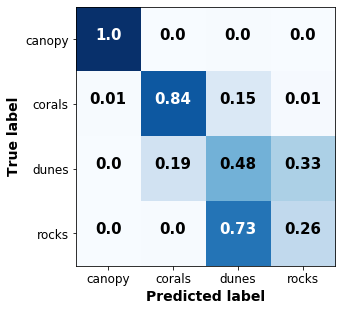

In [21]:
cm = confusion_matrix(ground_truth, predicted_classes)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, class_names)
plt.savefig('plots/Confusion_matrix_2D_{}.png'.format(im_type))
plt.show()